# Twitter's Climate Tide
## An Analysis of Tweets About Climate Change 
### By Arjun Gandhi
### Last updated: December 14, 2020
### CURRENTLY THIS IS A DRAFT, NOT THE FINAL SUBMISSION.

# Installations and imports

In [1]:
# Wordcloud
#!pip install wordcloud

# Seaborn
#!pip install seaborn --upgrade
# Gensim
#!pip install --upgrade gensim

# Spacy
#!pip install -U spacy
#!pip install -U spacy-lookups-data
#!python -m spacy download en_core_web_sm

### The libraries used are: [matplotlib](https://matplotlib.org/index.html#), [pandas](https://pandas.pydata.org), [spaCy](https://spacy.io), [seaborn](https://seaborn.pydata.org), [Gensim](https://radimrehurek.com/gensim/), [wordcloud](http://amueller.github.io/word_cloud/), [scikit-learn](https://scikit-learn.org/stable/), and [NLTK](https://www.nltk.org).

In [2]:
# The essentials/Python modules
import pandas as pd
import string
import re
import datetime
import random

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP and machine learning 
import spacy
import gensim
import nltk
# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [3]:
# NLTK downloaded need later that must go after import
# nltk.download('wordnet')

# Data Collection
I did not go and scrape Twitter to get all tweets that were on climate. Instead, I found a GWU dataset of climate change tweets that were collected from 2017-2019 (Littman, Justin; Wrubel, Laura, 2019, "Climate Change Tweets Ids", https://doi.org/10.7910/DVN/5QCCUU, Harvard Dataverse, V1). I downloaded my sample from GWU which makes picking your criteria for the tweets much easier. You can make your own data set from all 40 million right [here](https://tweetsets.library.gwu.edu/datasets).  Here is a link to my exact sample: http://tweetsets.library.gwu.edu/dataset/a66e1b6b. You can also see my sample in the form of the tweet ids in my GitHub repo: [arjungandhi521/arjungandhi521.github.io/public_data/tweets_25k.txt](https://github.com/arjungandhi521/arjungandhi521.github.io/blob/main/public_data/tweets_25k.txt). I sampled 25,000 of the 40 million tweets. The CSV I use directly below is private because of Twitter policy that one should not publish large amounts of tweets but that people in academics and such can go ahead and publisht the tweet ids. As states in the above link the data is from September 21, 2017 and May 17, 2019 and they had a gap in data collection from January 7, 2019 to April 17, 2019. I chose to exclude retweets and this sample ranges from late 2017 to mid-2019 which is the full collection time. I excluded retweets because even though a tweet with 1 billion RTs may have high influence on Twitter, having it n times in the dataset is not really going to add to my understanding of the language. I still have access to the favorites and retweets data which I will use later on. 

To convert each tweet ID into the actual tweet data I am using Hydrator: Hydrator [Computer Software]. Retrieved from https://github.com/docnow/hydrator. From the above repo, I downloaded [version 0.0.13 of the app](https://github.com/DocNow/hydrator/releases/tag/v0.0.13). I made a Twitter account to connect my account this Hydrator. When you download the sample just pick to download tweet ids. This will be a compressed .txt file. Just unzip it and then upload the file into Hydrator under "Datasets" in the desktop app. Then hit "Add Dataset" and then "Start" and then when its done you can click CSV to get the JSONL as a CSV. When I hydrated the tweets (turned them from tweet ids into tweets you see below), I started with 25,000 ids but the data frame directly below "only" has 18,328 tweets. This is for several reasons including people making their accounts private and deleted tweets and accounts. These tweet ids were put into the data set before these thing happend.

TALK ABOUT THEIR METHODOLOGY 

In [4]:
data = pd.read_csv("./data/tweets_25K.csv")
data

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Tue Dec 11 01:00:00 +0000 2018,UN cdnpoli ONpoli ABpoli,https://twitter.com/TheRebelTV/status/10722948...,https://www.therebel.media/un-global-warming-m...,91,1072294898588631040,NaN,NaN,NaN,...,205531,17484,1254,Canada and the world,Rebel News,RebelNewsOnline,39001,NaN,https://www.rebelnews.com,True
1,NaN,Mon Jan 22 09:49:35 +0000 2018,NaN,NaN,NaN,0,955376892026093569,Pontifex,9.551606e+17,500704345.0,...,1,4,0,United States,Frank,Frank34802901,100,NaN,NaN,False
2,NaN,Mon Sep 17 04:42:16 +0000 2018,NaN,NaN,https://truthout.org/articles/national-park-of...,0,1041547863795224576,NaN,NaN,NaN,...,2064,2383,98,USA,OurRevolution,LeftysUnite,50006,NaN,NaN,False
3,NaN,Sat Aug 04 13:02:13 +0000 2018,Spain Portugal climatechange globalwarming Hea...,NaN,https://news.sky.com/story/live-scorching-satu...,1,1025728615399469058,NaN,NaN,NaN,...,25,24,1,NaN,Steven Hugh,Steven9Hugh,1402,NaN,https://stevenhugh.wordpress.com/,False
4,NaN,Tue Nov 21 10:17:51 +0000 2017,Resist FakePresident Dontard GOP NRA War Clima...,NaN,https://twitter.com/mattmfm/status/93272970237...,0,932915956824682496,NaN,NaN,NaN,...,6198,6731,121,"the beautiful ""Jemez"" USA",Athoughtz,athoughtz,155949,NaN,http://TokTok.com,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18323,NaN,Tue Jan 16 06:51:55 +0000 2018,auspol solarenergy windpower Jobs environment ...,NaN,https://www.google.com.au/search?q=Morocco+and...,1,953157850536165376,JayWeatherill,NaN,350707926.0,...,2035,1288,500,South Australia,Gareth_A bot I'm not,Gareth_PanChem,140364,NaN,NaN,False
18324,NaN,Sat Dec 30 13:58:31 +0000 2017,NaN,NaN,https://twitter.com/MJ_Mouton/status/946959909...,0,947104617157992448,NaN,NaN,NaN,...,1977,1919,4,Southern California,👍 S. Christy 😃,SChristy16,236234,NaN,NaN,False
18325,NaN,Sun Oct 22 05:13:47 +0000 2017,NaN,NaN,http://www.asian-news-channel.tv/index.php/en/...,0,921967799781560322,NaN,NaN,NaN,...,1360,3206,7,New Delhi INDIA,Ramneet Kaur,RamneetANC,539851,NaN,http://www.asian-news-chanel.tv,False
18326,NaN,Sun Sep 24 04:22:35 +0000 2017,ClimateChangeIsReal,NaN,NaN,0,911808056693886977,NaN,NaN,NaN,...,268,282,36,"Chandigarh, Chandigarh India",Amit Sharma,amit219,25148,NaN,http://amit219.blogspot.com,False


As you can see, there is many columns. Most of these won't help me so many will have to go. Others need some fixing up to be useful like the date and time string need to be date objects.

# Data Wrangling
The data set has lots of data that is not needed for this analysis. Since we are looking at sentiment over time and other factors related to polticis of a state and events, it is simplest to just drop all non-English tweets.

There are lots of extranenous columns that are not relavent to this project so I just dropped them. These included geolocation data that was often missing, user information, and extranenous data about a tweet like time zone and lanague (since I drop all non-English ones to begin). These include things like user specifics like their profile details and other things like the URL of thr tweet or the language since all will be English. 

I followed this tutorial for help with tasks like lemmatization here and in the next section (EDA/Data Viz) making bags of words and word clouds.
https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/ 

## Remove non-English tweets and extraneous columns.

In [5]:
# Remove non-English tweets from the data set
data = data[data["lang"] == "en"]

# Drop all the unneeded columns from the data set
cols_to_delete = ["user_urls", "user_statuses_count", "coordinates", "user_name", "in_reply_to_status_id", 
                  "in_reply_to_user_id", "user_time_zone", "urls", "lang", "media", "source", 
                  "retweet_screen_name", "retweet_id", "possibly_sensitive", "tweet_url",
                  "user_default_profile_image", "user_friends_count", "user_verified", "user_location", 
                   "in_reply_to_screen_name", "user_screen_name.1",
                  "user_favourites_count", "user_listed_count", "user_created_at", "user_description", "place", 
                 "user_followers_count", "hashtags"]

data = data.drop(columns=cols_to_delete)

# Swap the index column from 0...n to the tweet ID and rename the column from id to tweetID and rename to clarify
# column meaning
data = data.rename(columns={"id": "tweetID", "created_at": "date/time", "user_screen_name": "tweeter"})
data = data.set_index('tweetID')
data

,date/time,favorite_count,retweet_count,text,tweeter
tweetID,,,,,
1072294898588631040,Tue Dec 11 01:00:00 +0000 2018,91,55,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline
955376892026093569,Mon Jan 22 09:49:35 +0000 2018,0,0,@Pontifex Prayers to God the one &amp; only t...,Frank34802901
1025728615399469058,Sat Aug 04 13:02:13 +0000 2018,1,0,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh
932915956824682496,Tue Nov 21 10:17:51 +0000 2017,0,0,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz
1041547806622797824,Mon Sep 17 04:42:02 +0000 2018,3,1,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg
...,...,...,...,...,...
1016831500015136768,Tue Jul 10 23:48:16 +0000 2018,2,0,#PLOSMedicine: #ClimateChange &amp; #WomensHea...,HEARDatUNSW
953157850536165376,Tue Jan 16 06:51:55 +0000 2018,1,0,@JayWeatherill #auspol. PHOTOVOLTAIC #solarene...,Gareth_PanChem
921967799781560322,Sun Oct 22 05:13:47 +0000 2017,0,0,EPA’s climate website removes resources to fig...,RamneetANC


## Combine the likes and retweets for total interaction score.

In [6]:
# Combine the number of favorites and retweets for a tweet into an total interactions score
total_interactions = []

for row in data.iterrows():
    tweet = row[1] 
    total = tweet["retweet_count"] + tweet["favorite_count"]
    total_interactions.append(total)

# Swap out the current RT and favorites columns for the total interactions columns
data["total_interactions"] = total_interactions
data = data.drop(columns=["retweet_count", "favorite_count"])
data.head()

,date/time,text,tweeter,total_interactions
tweetID,,,,
1072294898588631040,Tue Dec 11 01:00:00 +0000 2018,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146
955376892026093569,Mon Jan 22 09:49:35 +0000 2018,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0
1025728615399469058,Sat Aug 04 13:02:13 +0000 2018,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1
932915956824682496,Tue Nov 21 10:17:51 +0000 2017,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0
1041547806622797824,Mon Sep 17 04:42:02 +0000 2018,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4


## Convert the time/date strings into date objects using regular expressions.

In [7]:
# Convert the dates time strings into datetime objects
dates = []

# Matching this text
# Mon Jan 22 09:49:35 +0000 2018
# For every row in the dataframe
regex = re.compile(r"(\w{3}) (\w{3}) (\d\d) (\d\d:\d\d:\d\d) \+(0{4}) (\d{4})")

# Given a string of a month return the corresponding integer for that month i.e. Jan == 1
def numerize(str):
    month = str.lower()
    if (month == "jan"): return 1
    elif (month == "feb"): return 2
    elif (month == "mar"): return 3
    elif (month == "apr"): return 4
    elif (month == "may"): return 5
    elif (month == "jun"): return 6
    elif (month == "jul"): return 7 
    elif (month == "aug"): return 8
    elif (month == "sep"): return 9
    elif (month == "oct"): return 10
    elif (month == "nov"): return 11
    elif (month == "dec"): return 12
        
for row in data.iterrows():
    dt = row[1]["date/time"]
    matches = re.search(regex, dt)
    groups = matches.groups()    
    month = numerize(groups[1])
    d = datetime.date(int(groups[5]), month, int(groups[2]))
    dates.append(d)
    
data = data.drop(columns=["date/time"])
data["date_tweeted"] = dates
data.head()

,text,tweeter,total_interactions,date_tweeted
tweetID,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17


## Prepare the tweets for sentiment analysis
There are several things that need to be done to the actual text of the tweets before we can do sentiment analysis on them. To starts of, I will do some basic things like make all tweet bodies lower case so that words like CLIMATE and climate and cLiMate are all treated the same by the model I use later on. Next, I am going to remove all links from these tweets because that is irrelvanet to the sentiment of the tweet. There are many things like this that I will do here then I will move on to make the tweets "linguistically sound" for analysis by doing things like removing words without meaning that won't contribute the analysis and then making all words their base word or lemmatizing them.

### Remove links

In [8]:
linkless = []
regex = re.compile(r"http\S+")

# remove all links from each tweet
for row in data.iterrows():
    txt = row[1]["text"]
    if txt.find("https://t.co"): 
        ll = re.sub(regex, "", txt)
        linkless.append(ll)
    else: 
        linkless.append(txt)

data["text"] = linkless
data.head()

,text,tweeter,total_interactions,date_tweeted
tweetID,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17


### "Preprocess" the tweets
I will be using GenSim to do much of the natural langauge processing in this project. "Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long."
#### Tokenization
Tokenization a fundemental first step before you do anything in code with natural language to understand it. Tokenization is taking a piece of text like "Python is the best" and making into a list of the words that make up that text so here that would be ["Python", "is", "the", "best"]. You can find a more in-depth explanation of tokenization here if you're so interested: https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/. Though I never explicity call something like tokenize(tweet), the preprocess function right here and the lemmatize later on are doing this. The reasons I do this twice is I want to clean up the tweet before I lemmatize (explained later) and lemmatize needs a string not a string list.

In [9]:
tweets = []
for r in data.iterrows():
    tweets.append(gensim.utils.simple_preprocess(r[1]["text"]))
    
data["tokens"] = tweets 
data.head()

,text,tweeter,total_interactions,date_tweeted,tokens
tweetID,,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11,"[therebeltv, goes, to, two, different, un, con..."
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22,"[pontifex, prayers, to, god, the, one, amp, on..."
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04,"[red, alert, in, spain, and, portugal, as, eur..."
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21,"[trump, gop, are, the, swamp, resist, fakepres..."
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17,"[study, green, buildings, save, billion, in, h..."


### Stopwords and Lemmatization 
Here I will remove stopwards from the tweet bodies. These are words like "I" and "this" that add little meaning to the tweet but if left in the text will give me an innacurate depiction of the most common words in the tweets. Thne I will perform lemmatization on the tweets. This just means taking words that linguisticlly mean the same thing like walker and walking and reducing them to their base. In this case the word walk. You can read more here: https://en.wikipedia.org/wiki/Lemmatisation. 

In [10]:
# Load the model 
model = spacy.load('en_core_web_sm')

lemmatized = []
# Lemmatization of tweets and stopwords removal
for r in data.iterrows():
    tweet = r[1]["tokens"] # get tokens
    text = " ".join(tweet) # need as string to lemmatize
    lemmas = [tok.lemma_ for tok in list(model(text)) if (tok.is_stop==False)] # lematize
    lemmatized.append(lemmas) # save lemma tokens
    
data["tokens"] = lemmatized
data.head()

,text,tweeter,total_interactions,date_tweeted,tokens
tweetID,,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11,"[therebeltv, go, different, un, conference, me..."
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22,"[pontifex, prayer, god, amp, true, father, jes..."
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04,"[red, alert, spain, portugal, europe, near, ti..."
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21,"[trump, gop, swamp, resist, fakepresident, don..."
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17,"[study, green, building, save, billion, health..."


# Exploratory Data Analysis and Data Visualization

In this section, I will look at a number of aspects of the data. I will start off by just looking at when do people tweet about climate the most. Then I will do a number of word cloud visuazlaitons by things like year and peak times for tweeting about climate. To do these, I create bags of words and then sum over the rows so I make the word cloud using a one row data frame. Then I will look at the "length" of the tweet (normalzied for stopwords and semantically useless words). Finally, I will visualize a distribution of who is tweeting about climate as in how much are different people contributing to the data.

In addition to the I mentioned above (https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/), I also referenced here to make word cloud visualizations.

## Frequency of Climate Tweets over Time

In [11]:
# To make splitting up the data frame up by time easier, I will add a year column to the tweet
years = []
for r in data.iterrows(): years.append(r[1]["date_tweeted"].year)
data["year"] = years
data.head()

,text,tweeter,total_interactions,date_tweeted,tokens,year
tweetID,,,,,,
1072294898588631040,.@TheRebelTV goes to two different #UN confere...,RebelNewsOnline,146,2018-12-11,"[therebeltv, go, different, un, conference, me...",2018
955376892026093569,@Pontifex Prayers to God the one &amp; only t...,Frank34802901,0,2018-01-22,"[pontifex, prayer, god, amp, true, father, jes...",2018
1025728615399469058,Red alert in #Spain and #Portugal as Europe ne...,Steven9Hugh,1,2018-08-04,"[red, alert, spain, portugal, europe, near, ti...",2018
932915956824682496,Trump /GOP are the swamp #Resist #FakePresiden...,athoughtz,0,2017-11-21,"[trump, gop, swamp, resist, fakepresident, don...",2017
1041547806622797824,Study: Green Buildings Save $6.7 Billion in #H...,IndiaGreenBldg,4,2018-09-17,"[study, green, building, save, billion, health...",2018


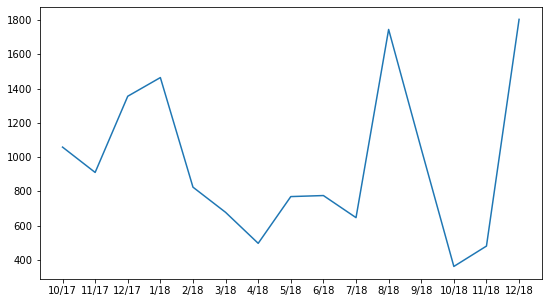

In [12]:
# Are there times where people tweet about climate change more than others?
# To make things simple lets look at the number of tweets per month year pair in the dataset
tweets_per_month = {}

# As you may recall data was collected from September 21, 2017 and May 17, 2019 and they had a gap in 
# data collection from January 7, 2019 to April 17, 2019.

# Initalize the value for a tuple key for the month/year pair to 0 for all months where data was collected
# 2017
for i in [9, 10, 11, 12]: 
    tweets_per_month[(i,2017)] = 0
# 2018
for i in range(1,13): 
    tweets_per_month[(i,2018)] = 0
# 2019
for i in [1, 4, 5]: 
    tweets_per_month[(i,2019)] = 0
    
# Iterate over data frame and add one to each tweet's proper month/year tuple's value
for r in data.iterrows():
    row = r[1]
    date = row["date_tweeted"]
    tweets_per_month[(date.month, date.year)] += 1
    
# Remove Septembr 2017 and January-April 2019 because most during most the month data was not collected
tweets_per_month.pop((9, 2017))
tweets_per_month.pop((1, 2019))
tweets_per_month.pop((4, 2019))
# I decided to also drop May 2019 from this visualization because if I leave it then there is a 5 month gap in
# data and this is not reflected in the plot.
tweets_per_month.pop((5, 2019))

# Convert the tuples to strings
time = list(tweets_per_month.keys())
count = list(tweets_per_month.values())

dates = []
for t in time: 
    dates.append(str(t[0]) + "/" + str(t[1])[-2:])
    
df = pd.DataFrame(columns = ['date', 'tweet_count'])
df['date'] = dates
df['tweet_count'] = count

plt.figure(figsize=(9, 5))
plt.plot(dates,count)

*THIS MAY NEED TO BE UPDATED BASED ON HOW THE GWU PEOPLE SAMPLED*

As you can see there were several time periods where the frequency of tweeting about climate was a bit higher than others, August and December 2018. I will look into these time periods a bit more below. Though, we can see that for the most part, people tweet a good amount about climate throughout the year and there really isn't one obvious patter that we can learn from this graph other than maybe people tweet alot about climate in the spring but again we are only looking at limited data so that inference is hard to make.

## Word Cloud Visualizations

In [13]:
# make bag of words
cv=CountVectorizer(analyzer='word')

# add a column with the text of each tweet as one string
tweets = []
for r in data.iterrows():
    tweets.append(" ".join(r[1]["tokens"]))
    
data["tweet"] = tweets

# define a function that takes in a data frame of tweets and returns a bag of words w/ the help of sklearn
def make_bag_of_words(tweets):
    info = cv.fit_transform(tweets["tweet"])
    bow = pd.DataFrame(info.toarray(), columns=cv.get_feature_names())
    bow.index=tweets.index
    # drop the &amp column bc this is a not a word and shows up much in the word clouds and is HTML of &
    bow.drop(columns=["amp"], inplace=True)
    return bow

# make a bag of words for each year i have data on
bags = []
for i in range(2017,2020): 
    bags.append(make_bag_of_words(data[data["year"] == i]))
    
# example output for 2019
bags[2].head()

,aanthanurdc,aaronbastani,ab,abandon,abbiedillen,abbott,abc,abcnew,abcnews,abdkabir,...,ºc,𝒢𝓁𝑜𝒷𝒶𝓁,𝒲𝒶𝓇𝓂𝒾𝓃𝑔,𝒾𝓈𝓃,𝓇𝑒𝒶𝓁,𝗳𝗶𝗿𝗲,𝗶𝘀,𝗼𝗻,𝗽𝗹𝗮𝗻𝗲𝘁,𝘁𝗵𝗲
tweetID,,,,,,,,,,,,,,,,,,,,,
1129451400457543681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129451354920030208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129451429364502529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129451461426012160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129451476517085185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Shockingly, you probably aren't getting much insight from looking at this massisve matrix of mostly 0s. So lets create a function to take that data and make it into a word cloud!

2017 Climate Change Tweets


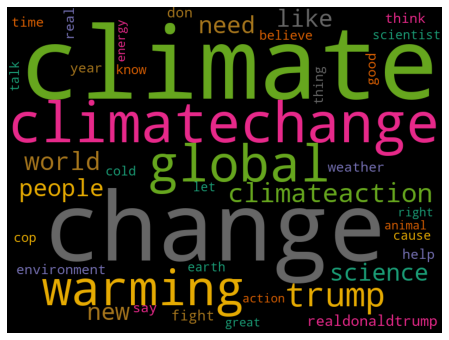

2018 Climate Change Tweets


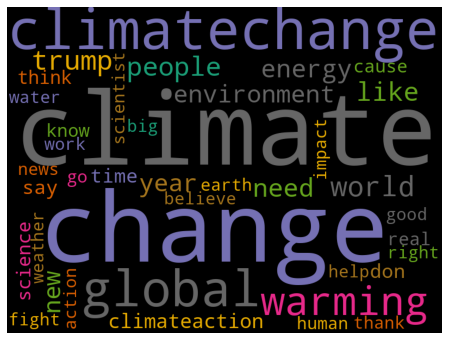

2019 Climate Change Tweets


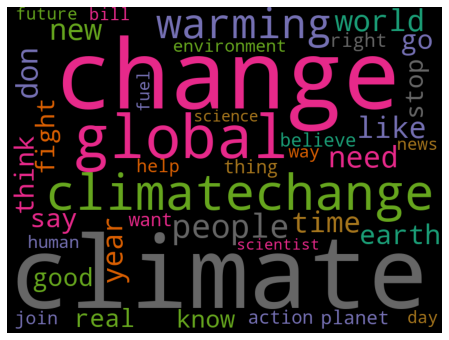

In [14]:
# I made a function that will display a word cloud give the word frequencies as a df
def make_word_cloud(freqs):
    wc = WordCloud(width=800, height=600, max_words=40,colormap="Dark2").generate_from_frequencies(freqs.sum())
    plt.figure(figsize=(8,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

# Call make word cloud each bag of words summed so its one row for all tweets in that year (2017-19)
title = ["2017", "2018", "2019"]
for i in range(3): 
    print(title[i]+ " Climate Change Tweets")
    make_word_cloud(bags[i])

At a first glance, it does not look like the words people use to tweet about climate are all that different year over year. Its lots of "climate change", "#climatechagne", "global warming", "world", and different strings refering to President Trump. But do keep in mind the data from 2018 dominates that data set and we only have data from the start of 2019 and end of 2017.

### Most interacted with tweets
Here I will use the WordCloud library to visualize the 500 most interacted with tweets. I define an interaction as a favorite or retweet and I weighted them equally when I combined the two earlier.

Top 500 Most Interacted With Tweets


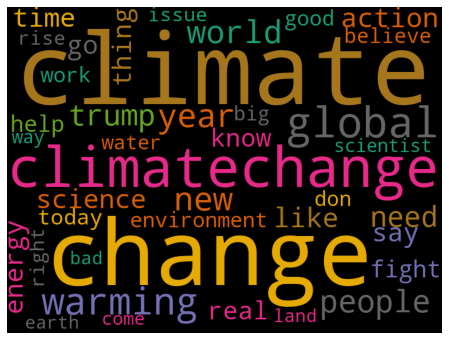

In [15]:
# Make a word count of the most interacted with tweets (what got the most likes and retweets)
data = data.sort_values(by=["total_interactions"], ascending=False)
top_500 = data.head(500)
print("Top 500 Most Interacted With Tweets")
make_word_cloud(make_bag_of_words(top_500))

It looks like the popular kids on Twitter are largely tweeting the same words as everyone else. Could be interesting later on to see if they have a different sentiment though?!

### During the peak times for climate on Twitter, what were people tweeting about? Was it a natural distaster, a political move, something else, or nothing special?

August 2018 Climate Change Tweets


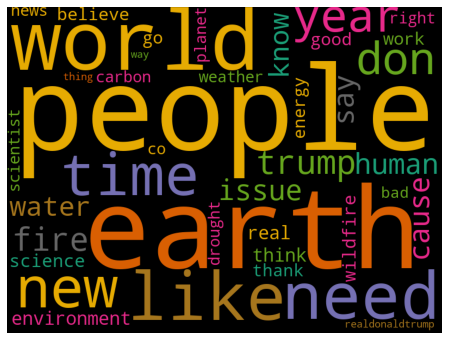

In [16]:
# I want to see what was "special" about these time frames so I will remove the words that are always most popular
popular = ["climate", "change", "global", "warming", "climatechange"]

# Make a word cloud for August 2018
# Ends of August 2018
aug1 = datetime.date(2018, 8, 1) 
aug31 = datetime.date(2018, 8, 31) 
# Get he df for august
eighteen = data[data["year"] == 2018] # 2018 df
aug_on = eighteen[eighteen["date_tweeted"] >= aug1]
aug2018 = aug_on[aug_on["date_tweeted"] <= aug31]
# Get the bow
bow_aug = make_bag_of_words(aug2018).drop(columns=popular)
# Call make word cloud
print("August 2018 Climate Change Tweets")
make_word_cloud(bow_aug) 

August is in one of California's wildfire seasons according and at that time this was [the most deadly and destructive fire season in California](https://en.wikipedia.org/wiki/2018_California_wildfires) so it makes a lot of sense that we see fire related terms in the August 2018 word cloud. 

December 2018 Climate Change Tweets


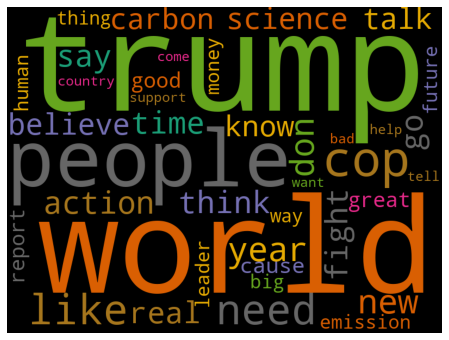

In [17]:
# Do the same for December 2018
start = datetime.date(2018, 12, 1) # start of december
december_2018 = eighteen[eighteen["date_tweeted"] >= start] # december 2018 df
# make bag of words and drop most popular terms
bow_d18 = make_bag_of_words(december_2018).drop(columns=popular) 
# make word cloud
print("December 2018 Climate Change Tweets")
make_word_cloud(bow_d18) 

Interesting, after looking through some headlines to see if I could find why the most dominant term here (Trump) was so dominant in this month specifically though after looking through the tweets about Trump from this month several were about the G-20 conference but not all.

## "Length" of Tweet

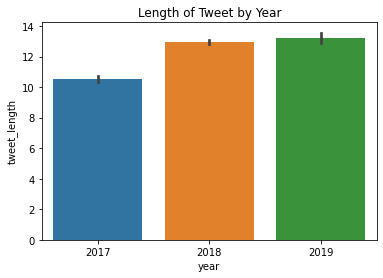

In [18]:
data['tweet_length']=data['tokens'].apply(lambda tokens: len(tokens))
sns.barplot(x='year',y='tweet_length',data=data).set(title="Length of Tweet by Year")

# go ahead the drop the tweet length so df is more readable/short width later on
data = data.drop(columns=["tweet_length"])

Recall that the length of the Tweet that we are looking at here is approximate because we removed things like links (which are notably not words) and GenSim's preprocess() function removes very short and long words from the tweets to help me get the most semantically meanigful words from the tweets.

When looking at this graph one major thing to consider is that it may not be such a simple oh tweet length about climate must be going up year after year for a couple of reasons. One major factor is the sample from 2018 is much larger than the other two because the majority of data colleciton took place in 2018 and much of Jan-Apr 2019 lacked sampling. In 2019, GWU collected data the first week of January, not at all in Feb-Mar, the last two weeks of April, and most of May.

So roughly speaking we can say that tweet length may have increased when talking about tweets related to climate change but because of what I just said this is at best a rough guess because we aren't really saying massive changes in length for example between 2018 and 2019.

## Are we just seeing a few dominant voices on Twitter?
Lets look at the distribution of tweet count about climate to see if these most of these tweets are coming from a few tweeters.

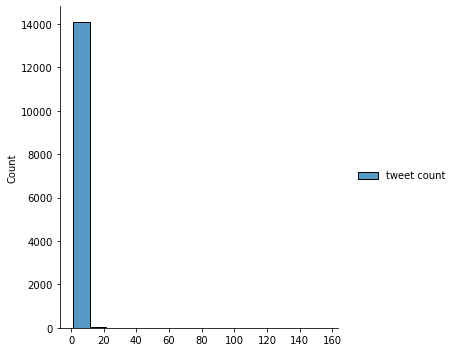

In [19]:
# set of tweeters 
tweeters = list(set(data["tweeter"]))
times_tweeted = dict.fromkeys(tweeters , 0)

# Calculate how many times each tweeter has tweeted
for r in data.iterrows():
    row = r[1]
    user = row["tweeter"]
    times_tweeted[user] += 1
    
users = list(times_tweeted.keys())
counts = list(times_tweeted.values())

df = pd.DataFrame(columns = ['user', 'tweet count'])
df["user"] = users
df["tweet count"] = counts
sns.displot(df)

Nearly every person in the data set has tweeted between 1-10 times about climate. This plot is very skewed (right). So we are NOT just seeing a few voiced but many voices on climate! 

# Machine Learning and Sentiment Analysis
For my section on machine learning I going to primarily focus on sentiment analysis. I will give a brief introduction to what that is but if you are interesting in learning more, I would reccommend that you check out these links that dive deeper and may explain it a bit better: https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17, https://monkeylearn.com/sentiment-analysis/.

So what is sentiment analysis? On a basic level its looking at the words used in a piece of text like "Climate change is my favorite thing to tweet about 😍." and seeing if the text is neutral, positive, or negative. This example would likely be said to have positive sentiment based on the word favorite and the emoji if that was considered in the calculation.

Something to conisder here: ["U.S. adult Twitter users are younger and more likely to be Democrats than the general public"](https://www.pewresearch.org/internet/2019/04/24/sizing-up-twitter-users/). I do realize that every young Democrat cares about the planet but we need to consider this when looking at sentiment. This is sort of obvious later on when I looked at the number of positive vs number of negative tweets about climate that I can label based on the words used (directly below) because there are SO MANY more tweets that are positive that I am able to label about climate than the negative ones.

### Labeling tweets as positve or negative

In [20]:
# If the tweet has a positive word then label it positive, else if has negative word label it negative
positive_words = ["real", "action", "emergency", "crisis", "believe", "issue","fight","science","trump", "save", 
     "great", "good", "like", "impact", "don", "stop", "end"]

negative_words = ["hoax","fake","false","fraud","lie","scam","fakenews","climatehoax","maga", "bad", "weak", 
                  "waste"] 

# Double check the words you chose are all lemmas
lemmatized_pos = []
lemmatized_neg = []
lemmatizer = nltk.stem.WordNetLemmatizer() 
  
for word in negative_words: 
    lemmatized_neg.append(lemmatizer.lemmatize(word))
for word in positive_words: 
    lemmatized_pos.append(lemmatizer.lemmatize(word))
    
print("positive lemmas are",lemmatized_pos,"\n")
print("negative lemmas are",lemmatized_neg)

# Just in case
positive_words = lemmatized_pos
negative_words = lemmatized_neg

positive lemmas are ['real', 'action', 'emergency', 'crisis', 'believe', 'issue', 'fight', 'science', 'trump', 'save', 'great', 'good', 'like', 'impact', 'don', 'stop', 'end'] 

negative lemmas are ['hoax', 'fake', 'false', 'fraud', 'lie', 'scam', 'fakenews', 'climatehoax', 'maga', 'bad', 'weak', 'waste']


All the words I chose were lemmas already but I will use the lemmas below just in case I channge any of the sentiment indicating words or in case I made a mistake comparing the lists.

### Find synomns of the words chosen above using NLTK
I am doing this to increase the number of tweets that I can mark with positive or negative sentiment. With more words to look for to indicate sentiment, we will be able to label lots more tweets as positive or negative for the training data set. To figure out how to use NLTK to do this I referenced this [article](https://www.guru99.com/wordnet-nltk.html).

In [53]:
# Make a function that returns a set of synomons given a list of words
def find_set_of_synomns(word_lst):
    synonyms = []
    antonyms = []
    for word in word_lst:
        for synonym in nltk.corpus.wordnet.synsets(word):
            for lemma in synonym.lemmas():
                #print(lemma.name())
                synonyms.append(lemma.name())
    return set(synonyms)
    
# Use it to make sets of positive words and their synomns
syns_pos = find_set_of_synomns(positive_words)
syns_neg = find_set_of_synomns(negative_words)

positive_words = syns_pos | set(positive_words)
negative_words = syns_neg | set(negative_words) 

print("the negative words are:")
print(negative_words)

the negative words are:
{'get_away', 'heist', 'deconsecrate', 'muddle', 'metre', 'buff', 'qualification', 'female_monarch', 'receding', 'man-made', 'disassociation', 'saturation', 'melange', 'affix', 'churr', 'malodor', 'unquietly', 'guttle', 'RA', 'interfere', 'gallous', 'state', 'enfold', 'palatable', 'panic_attack', 'reckless', 'hidrosis', 'literal', 'wool', 'grainy', 'storey', 'wiggle', 'mental_confusion', 'live_up_to', 'Clay', 'buck_private', 'congeal', 'debauch', 'gonorrhoea', 'sunburn', 'modelling', 'bifurcate', 'figure', 'devolve_on', 'wasting_away', 'managing_director', 'bunce', 'wipe_off', 'reappearance', 'fiesta', 'III', 'open', 'saddle', 'thus_far', 'foliation', 'seedy', 'ca-ca', 'pedagogics', 'planning', 'enraged', 'cozen', 'mill', 'forrard', 'icing_the_puck', 'paraphernalia', 'unfounded', 'flirt', 'communique', 'scorch', 'concealed', 'customer', 'lambency', 'vapourisable', 'litigate', 'troth', 'slender', 'fussiness', 'gloominess', 'peace-loving', 'staff_of_life', 'dwarf',

### Assign sentiment labels to tweets

In [57]:
sentiment = []
nones = 0 # counter to see how many were neutral
bi = 0

# Constants used to indicate sentiment
POSITIVE = 1
NEGATIVE = -1
NEUTRAL = 0

# go through each tweet and see if there is a set intersection between the tweet's tokens as a set and the positive
# or negative word sets or both or neither
for r in data.iterrows():
    tweet = set(r[1]["tokens"])
    # if it has positive and negative terms its neutral
    # this case is VERY COMMON SO PICK A RANDOM LABEL TO INSURE MOST OF DATA IS LABELED
    if (tweet & negative_words) and (tweet & positive_words): 
        sentiment.append(random.choice([POSITIVE,NEGATIVE]))
    elif positive_words & tweet:
        sentiment.append(POSITIVE)
    elif negative_words & tweet:
        sentiment.append(NEGATIVE)        
    # if has none of these terms then neutral
    # this really does not have much influnce, this case happens 203 times out of 16,000+ runs
    # also use random here
    else:
        sentiment.append(random.choice([POSITIVE,NEGATIVE]))
        nones += 1
        
data["sentiment"] = sentiment
data.head(50)

,text,tweeter,total_interactions,date_tweeted,tokens,year,tweet,sentiment
tweetID,,,,,,,,
1128014614845743104,*Bill Nye drops F-bombs &amp; lights globe on ...,Liz_Wheeler,7275,2019-05-13,"[bill, nye, drop, bomb, amp, light, globe, fir...",2019,bill nye drop bomb amp light globe fire blow t...,-1
1080883217773645825,While there is certainly nothing wrong with ma...,leafwax,2189,2019-01-03,"[certainly, wrong, make, individual, low, carb...",2019,certainly wrong make individual low carbon cho...,-1
963505395871383552,Antarctica is home to these penguins and many ...,MarkRuffalo,1739,2018-02-13,"[antarctica, home, penguin, amazing, creature,...",2018,antarctica home penguin amazing creature globa...,1
1120652501374709760,📸 @IanBlackfordMP - along with other Westminst...,theSNP,1198,2019-04-23,"[ianblackfordmp, westminster, opposition, lead...",2019,ianblackfordmp westminster opposition leader m...,1
1026707053417381890,I really want to take this moment to thank the...,ChocoHarveyMilk,1195,2018-08-07,"[want, moment, thank, thousand, responder, wor...",2018,want moment thank thousand responder world fig...,1
1124429033708638210,Today is a big day for positive action on #cli...,gmbutts,1072,2019-05-03,"[today, big, day, positive, action, climatecha...",2019,today big day positive action climatechange co...,-1
1068678965609594881,Michael Cohen guilty plea \nSouthwest Air mock...,juliareinstein,1063,2018-12-01,"[michael, cohen, guilty, plea, southwest, air,...",2018,michael cohen guilty plea southwest air mocks ...,-1
1120111015075540992,"""Contrary to belief, there is business support...",JeremyLeggett,1031,2019-04-21,"[contrary, belief, business, support, agenda, ...",2019,contrary belief business support agenda welcom...,-1
1122635604183773185,"Every year, the world's five largest publicly ...",PaulEDawson,938,2019-04-28,"[year, world, large, publicly, own, oil, gas, ...",2019,year world large publicly own oil gas company ...,1


### How much training data do we end up with?

In [55]:
#TOTAL_NUMBER_OF_TWEETS = len(data.index)
#print(int((nones/TOTAL_NUMBER_OF_TWEETS) * 100), "% of the tweets did not get a sentiment label.")

1 % of the tweets did not get a sentiment label.


This is not great *ugh*. This means we have 48% of the data to train on (i.e. 100%-52%). Though even after looking at tools like [snorkel](https://www.snorkel.org) and their tips for how to label data, I think it would be difficult to accurately label more tweets than we already have. I know that the metrics I am using here to label training data are VERY rough and so this labeling will often be wrong but its not realistic to label all 16K+ tweets using this method or by ahdn. So, it would have been better if I could come to you with 80% of the data ready for training but alas, not today. The good news is there will be lots of room for the data to social distance when they are in the gym to training the model.

### Assembly a training data set

In [58]:
# Make dfs for training data
positives = data[data["sentiment"] == POSITIVE]
negatives = data[data["sentiment"] == NEGATIVE]

# Combine the positive and negative training sets
df_train = positives.append(negatives)
df_train

,text,tweeter,total_interactions,date_tweeted,tokens,year,tweet,sentiment
tweetID,,,,,,,,
963505395871383552,Antarctica is home to these penguins and many ...,MarkRuffalo,1739,2018-02-13,"[antarctica, home, penguin, amazing, creature,...",2018,antarctica home penguin amazing creature globa...,1
1120652501374709760,📸 @IanBlackfordMP - along with other Westminst...,theSNP,1198,2019-04-23,"[ianblackfordmp, westminster, opposition, lead...",2019,ianblackfordmp westminster opposition leader m...,1
1026707053417381890,I really want to take this moment to thank the...,ChocoHarveyMilk,1195,2018-08-07,"[want, moment, thank, thousand, responder, wor...",2018,want moment thank thousand responder world fig...,1
1122635604183773185,"Every year, the world's five largest publicly ...",PaulEDawson,938,2019-04-28,"[year, world, large, publicly, own, oil, gas, ...",2019,year world large publicly own oil gas company ...,1
991671093130940417,Why #scicomm about #climatechange is not that ...,saracole,932,2018-05-02,"[scicomm, climatechange, easy, scientist, publ...",2018,scicomm climatechange easy scientist public he...,1
...,...,...,...,...,...,...,...,...
960304593103024128,We have to keep drumming the message that #cli...,PatriciaMallam,0,2018-02-05,"[drum, message, climatechange, fact, century, ...",2018,drum message climatechange fact century big fi...,-1
963061382328365058,I join \n,Mukul585Huda,0,2018-02-12,[join],2018,join,-1
1019987253463060480,"@Tampa_Joe_813 @sciam Yes, but climate change ...",Kind_Geek,0,2018-07-19,"[tampa_joe, _, sciam, yes, climate, change, fa...",2018,tampa_joe _ sciam yes climate change fact fact...,-1


### Bias in the above training data
As you can see I labeled MANY more tweets with a positive sentiment than negative at a rate of about 15 times more for positive tweets. So this probably looks VERY questionable. I agree. It may or may not actually be like this on all of Twitter but lets consider a few things. One, remember [this Pew article I linked a bit ago](https://www.pewresearch.org/internet/2019/04/24/sizing-up-twitter-users/)? Well, based on their findings this is what I should expect with more youngsters Democrats on Twitter than the US population. Two, remember, I did NOT hand label tweets and the method I did for labeling them automatically was very much guessing to a degree.

In [60]:
print("I labeled", len(positives.index), "tweets with a positive sentiment.")
print("I labeled", len(negatives.index), "tweets with a negative sentiment.")

I labeled 8491 tweets with a positive sentiment.
I labeled 8324 tweets with a negative sentiment.


### Tranform documents into feature vectors
ENGLISH ARJUN FOR THE GRADER AND ALL PLEASE?

In [64]:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

# tranform the documents to feature vectors
count_vect = CountVectorizer()
training_data = data.head(8000)
X_train_counts = count_vect.fit_transform(training_data["tweet"])

# Make sure this checks out by seeing the count on a common word
print(count_vect.vocabulary_.get(u'climate'), count_vect.vocabulary_.get(u'change'))

3034 2673


This seems to be correct!

### TF-IDF

In [65]:
# Perform TF-IDF to account for occurance of a word more often in a longer tweet
tfidf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts) # fit estimator to data
X_train_tfidf = tfidf_transformer.transform(X_train_counts) # transform the count matrix into a tf-idf representation
X_train_tfidf.shape

(8000, 18866)

In [67]:
# Train the classifier
clf = MultinomialNB().fit(X_train_tfidf, training_data["sentiment"])
clf

MultinomialNB()

### Prediction time!

In [68]:
X_new_counts = count_vect.transform(Y_test)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted
#neutral["sentiment"] = predicted
#neutral.head()
# It always predictions positive sentiment?

array([ 1,  1, -1, ...,  1,  1,  1])

In [31]:
# Do some maths to show how bad this was?

In [32]:
# Can I do better with a SVM?

### So do my prediction mean anything compared to other sentiment analysis tools?

In [33]:
# Use textblob to see what sentiment they would predict and see how often we match

# What Insight Have We Gained?

# Wrap Up

## The Jupyter Notebook
You can find the original Jupyter Notebook file right here: [arjungandhi521/arjungandhi521.github.io/Climate Change on Twitter.ipynb](https://github.com/arjungandhi521/arjungandhi521.github.io/blob/main/Climate%20Change%20on%20Twitter.ipynb)

## Acknowledgements
I would like to thank the George Washington University's TweetSets organization for their data set on climate change on Twitter. Their data and website to sample the data set made this project so much easier. Once again all of their data sets from Twitter can be found right [here](https://tweetsets.library.gwu.edu).

I would also like to thank the UMD CMSC320 insturctional staff for all their help with this project, it is much appreciated.